<a href="https://colab.research.google.com/github/diNAZAvRik125/GNN_bmm23/blob/main/GNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
import os.path as osp
import json
import shutil
import pprint
import pandas as pd
import numpy as np

In [2]:
os.chdir('/content')

In [3]:
!git clone https://github.com/GraphGiraffe/GNN_bmm23.git
!ls GNN_bmm23

Cloning into 'GNN_bmm23'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 35 (delta 16), reused 35 (delta 16), pack-reused 0
Unpacking objects: 100% (35/35), 38.24 KiB | 2.39 MiB/s, done.
data_utils.py  GNN_models.py	      training.py	 utils.py
GNN_layers.py  preprocess_dataset.py  training_utils.py  visualize.py


In [4]:
!pip install torch_geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 22.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=1bf04f06f7dd7d91bb307832eba455c27b0506dd7a58c84ef558a63dbdcf46de
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 36.7 MB/s eta 0:00:00


In [5]:
import torch
from torch_geometric.loader import DataLoader

In [6]:
os.chdir('/content/GNN_bmm23')

In [7]:
from GNN_models import FlowGNN
from data_utils import read_dataset, make_dataset
from training_utils import train_model, loss_mae, loss_mse

# Download data

In [8]:
import gdown

if not osp.exists('data.tar.gz'):
  url = 'https://drive.google.com/uc?id=1abMcm4HTuXwQ453lpa9EKQ2zazKZB2wz'
  output = 'data.tar.gz'
  gdown.download(url, output, quiet=False)
else:
  print('file exists')

Downloading...
From: https://drive.google.com/uc?id=1abMcm4HTuXwQ453lpa9EKQ2zazKZB2wz
To: /content/GNN_bmm23/data.tar.gz
100%|██████████| 472M/472M [00:02<00:00, 169MB/s]


In [9]:
os.makedirs('datasets', exist_ok=True)

In [10]:
!tar -zxvf data.tar.gz --directory datasets/

Выходные данные были обрезаны до нескольких последних строк (5000).
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/002596.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000381.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/001921.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/001909.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/001510.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000197.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000829.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000815.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/002970.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/002637.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000034.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/000008.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/002186.csv
dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/elements/00079

In [11]:
!ls -alhtr

total 451M
drwxr-xr-x 1 root root 4.0K Jul 19 09:02 ..
-rw-r--r-- 1 root root 6.9K Jul 19 09:02 GNN_models.py
-rw-r--r-- 1 root root 2.8K Jul 19 09:02 GNN_layers.py
-rw-r--r-- 1 root root   19 Jul 19 09:02 .gitignore
-rw-r--r-- 1 root root 9.5K Jul 19 09:02 visualize.py
-rw-r--r-- 1 root root 4.6K Jul 19 09:02 utils.py
-rw-r--r-- 1 root root 6.5K Jul 19 09:02 training_utils.py
-rw-r--r-- 1 root root 3.1K Jul 19 09:02 training.py
-rw-r--r-- 1 root root  577 Jul 19 09:02 preprocess_dataset.py
drwxr-xr-x 8 root root 4.0K Jul 19 09:02 .git
-rw-r--r-- 1 root root 9.6K Jul 19 09:02 data_utils.py
drwxr-xr-x 2 root root 4.0K Jul 19 09:03 __pycache__
-rw-r--r-- 1 root root 451M Jul 19 09:03 data.tar.gz
drwxr-xr-x 5 root root 4.0K Jul 19 09:03 .
drwxr-xr-x 3 root root 4.0K Jul 19 09:03 datasets


# Prepare data

In [12]:
for root, dirs, files in os.walk('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/bcs/'):
  print(files)

dir_path = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/sv'
os.makedirs(dir_path, exist_ok=True)

def boundary_func(y, params):
  u0 = params[0]
  c1 = params[1]
  c2 = params[2]
  k1 = params[3]
  k2 = params[4]
  H = 6
  u = (u0 / 2) * (1 - (y / (H/2))**2) * ((1 + c1 * np.sin(k1 *y)) + (1 + c2 * np.sin(k2 * y)))
  return u
big_data_list = list()

for file_csv in files:
  way_to_csv = os.path.join(root, file_csv)
  data = pd.read_csv(way_to_csv, header=None)

  x_lin = np.linspace(-3,3,100)
  u = boundary_func(x_lin, [data[0][0],data[0][2],data[0][3],data[0][4],data[0][5]])

  big_data_list.append(u)
  df = pd.DataFrame.from_dict(u)
  df.to_csv(os.path.join(dir_path, file_csv))
  #plt.plot(x_lin, u)

big_data = np.vstack(big_data_list)
del big_data_list
df_big_data_speed = pd.DataFrame.from_dict(big_data)
df_big_data_speed.to_csv('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/res.csv', header=None)

['001372.csv', '002991.csv', '001122.csv', '000775.csv', '000080.csv', '002626.csv', '001110.csv', '000494.csv', '001285.csv', '000350.csv', '000368.csv', '002390.csv', '001430.csv', '000717.csv', '002367.csv', '000481.csv', '001371.csv', '001475.csv', '001981.csv', '002248.csv', '002207.csv', '002115.csv', '002929.csv', '002327.csv', '001155.csv', '001775.csv', '002392.csv', '001949.csv', '002171.csv', '001880.csv', '000821.csv', '001209.csv', '000876.csv', '002846.csv', '000600.csv', '002441.csv', '001874.csv', '002924.csv', '000671.csv', '002213.csv', '001499.csv', '001405.csv', '002513.csv', '001837.csv', '001518.csv', '000277.csv', '000574.csv', '002199.csv', '001118.csv', '002095.csv', '002870.csv', '002017.csv', '001817.csv', '001748.csv', '000902.csv', '002710.csv', '000213.csv', '002637.csv', '001298.csv', '000201.csv', '001328.csv', '000259.csv', '001169.csv', '002306.csv', '001718.csv', '002366.csv', '001825.csv', '000038.csv', '000635.csv', '002838.csv', '002522.csv', '0016

In [13]:
for root, dirs, files in os.walk('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/val/bcs/'):
  print(files)

dir_path = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/val/sv'
os.makedirs(dir_path, exist_ok=True)

def boundary_func(y, params):
  u0 = params[0]
  c1 = params[1]
  c2 = params[2]
  k1 = params[3]
  k2 = params[4]
  H = 6
  u = (u0 / 2) * (1 - (y / (H/2))**2) * ((1 + c1 * np.sin(k1 *y)) + (1 + c2 * np.sin(k2 * y)))
  return u
big_data_list = list()

for file_csv in files:
  way_to_csv = os.path.join(root, file_csv)
  data = pd.read_csv(way_to_csv, header=None)

  x_lin = np.linspace(-3,3,100)
  u = boundary_func(x_lin, [data[0][0],data[0][2],data[0][3],data[0][4],data[0][5]])

  big_data_list.append(u)
  df = pd.DataFrame.from_dict(u)
  df.to_csv(os.path.join(dir_path, file_csv))
  #plt.plot(x_lin, u)

big_data = np.vstack(big_data_list)
del big_data_list
df_big_data_speed = pd.DataFrame.from_dict(big_data)
df_big_data_speed.to_csv('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/val/res.csv', header=None)

['001372.csv', '002991.csv', '001122.csv', '000775.csv', '000080.csv', '002626.csv', '001110.csv', '000494.csv', '001285.csv', '000350.csv', '000368.csv', '002390.csv', '001430.csv', '000717.csv', '002367.csv', '000481.csv', '001371.csv', '001475.csv', '001981.csv', '002248.csv', '002207.csv', '002115.csv', '002929.csv', '002327.csv', '001155.csv', '001775.csv', '002392.csv', '001949.csv', '002171.csv', '001880.csv', '000821.csv', '001209.csv', '000876.csv', '002846.csv', '000600.csv', '002441.csv', '001874.csv', '002924.csv', '000671.csv', '002213.csv', '001499.csv', '001405.csv', '002513.csv', '001837.csv', '001518.csv', '000277.csv', '000574.csv', '002199.csv', '001118.csv', '002095.csv', '002870.csv', '002017.csv', '001817.csv', '001748.csv', '000902.csv', '002710.csv', '000213.csv', '002637.csv', '001298.csv', '000201.csv', '001328.csv', '000259.csv', '001169.csv', '002306.csv', '001718.csv', '002366.csv', '001825.csv', '000038.csv', '000635.csv', '002838.csv', '002522.csv', '0016

In [14]:
dataset_dir = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07'
data_list = [
    [osp.join(dataset_dir, 'train'), 'train.pt'],
    [osp.join(dataset_dir, 'val'), 'val.pt']
]
nodes_dim = 3  # x, y, obj

for data_dir, dataset_name in data_list:
    dataset = make_dataset(data_dir, 3000, with_bc=True,
                           norm_flow=False, norm_coord=True, save=True, dataset_name=dataset_name,
                           nodes_dim=nodes_dim)

flownorm1: tensor([ 0.5563, -0.0006,  0.2825,  0.4990], dtype=torch.float64)
flownorm2: tensor([0.3715, 0.1121, 0.2427, 0.0747], dtype=torch.float64)
range_flow: tensor([0.3715, 0.1121, 0.2427, 0.0747], dtype=torch.float64)


100%|██████████| 3000/3000 [00:47<00:00, 63.24it/s]


Saving : train.pt
Data: Data(x=[1918, 3], edge_index=[2, 10978], edge_attr=[10978, 3], flow=[1918, 4], bc=[1918, 6], cells=[3571, 3])
flownorm1: tensor([ 5.6416e-01, -5.1921e-04,  2.8514e-01,  4.9025e-01],
       dtype=torch.float64)
flownorm2: tensor([0.3780, 0.1142, 0.2490, 0.0760], dtype=torch.float64)
range_flow: tensor([0.3780, 0.1142, 0.2490, 0.0760], dtype=torch.float64)


100%|██████████| 3000/3000 [00:50<00:00, 59.62it/s]


Saving : val.pt
Data: Data(x=[1909, 3], edge_index=[2, 10894], edge_attr=[10894, 3], flow=[1909, 4], bc=[1909, 6], cells=[3538, 3])


# Read config

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg_path = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/gnn_skipBCFC_1500smpls_GP_coordnorm_flownorm_sc036912_8l_64N_v1.json'

with open(cfg_path, 'r') as f:
    cfg = json.load(f)
pprint.pprint(cfg)


{'dataset_cfg': {'csv_with_header': False,
                 'dirs': {'bcs': 'bcs',
                          'edges': 'edges',
                          'flow': 'flow',
                          'nodes': 'nodes'},
                 'geom_in_dim': 2,
                 'train_dataset_dir': 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train',
                 'train_dataset_name': 'train.pt',
                 'train_dataset_source_len': 3000,
                 'val_dataset_dir': 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/val',
                 'val_dataset_name': 'val.pt',
                 'val_dataset_source_len': 3000},
 'nn_cfg': {'batchnorm': [False,
                          False,
                          False,
                          False,
                          False,
                          False,
                          False,
                          False,
                          False,
                          False,
                          False,

In [16]:
dataset_cfg = cfg['dataset_cfg']
nn_cfg = cfg['nn_cfg']
train_cfg = cfg['train_cfg']

node_filters = nn_cfg['node_filters']
edge_filters = nn_cfg['edge_filters']
fc_in_dim = nn_cfg['fc_in_dim']
fc_out_dim = nn_cfg['fc_out_dim']
out_dim = nn_cfg['out_dim']
node_skip_cons_list = nn_cfg['node_skip_cons_list']
edge_skip_cons_list = nn_cfg['edge_skip_cons_list']
fc_con_list = nn_cfg['fc_con_list']
fc_hidden_layers = nn_cfg["fc_hidden_layers"]
batchnorm_layers = nn_cfg["batchnorm"]
selu = nn_cfg["selu"]

loss = train_cfg["loss"]
train_ratio = train_cfg['train_ratio']
valid_ratio = train_cfg['valid_ratio']
num_epochs = train_cfg['num_epochs']
decay_factor = train_cfg['decay_factor']
decay_step = train_cfg['decay_step']
batch_size = train_cfg['batch_size']

if loss == 'mae':
    loss_fn = loss_mae
elif loss == 'mse':
    loss_fn = loss_mse
else:
    raise RuntimeError('loss must be in ["mae", "mse"]')

out_dir = cfg['out_dir']
os.makedirs(out_dir, exist_ok=True)
shutil.copy(cfg_path, osp.join(out_dir, 'cfg.json'))

'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/gnn_skipBCFC_1500smpls_GP_coordnorm_flownorm_sc036912_8l_64N_v1/cfg.json'

# Create dataloaders

In [17]:
train_dataset = read_dataset(dataset_cfg['train_dataset_dir'],
                              dataset_cfg['train_dataset_source_len'],
                              dataset_cfg['train_dataset_name'])

val_dataset = read_dataset(dataset_cfg['val_dataset_dir'],
                            dataset_cfg['val_dataset_source_len'],
                            dataset_cfg['val_dataset_name'])

train_size = int(dataset_cfg['train_dataset_source_len'] * train_ratio)
val_size = int(dataset_cfg['val_dataset_source_len'] * valid_ratio)
train_dataset = train_dataset[:train_size]
val_dataset = val_dataset[:val_size]
test_dataset = val_dataset[val_size:]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_dataset[0])

3000
3000
Data(x=[1918, 3], edge_index=[2, 10978], edge_attr=[10978, 3], flow=[1918, 4], bc=[1918, 6], cells=[3571, 3])


# Train

In [18]:
gnn_model = FlowGNN(edge_filters, node_filters, fc_in_dim, fc_out_dim,
                    fc_con_list=fc_con_list, fc_hidden_layers=fc_hidden_layers,)

optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_factor)
train_loss_hist, val_loss_hist, _ = train_model(gnn_model, train_dataloader, val_dataloader,
                                                device, num_epochs, optimizer, scheduler, loss_fn,
                                                out_dir, collect_grads=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 0/50
train loss 0.20552662014961243 val loss 0.1747056394815445
Saved best model
Epoch: 1/50
train loss 0.1506980061531067 val loss 0.1384558528661728
Saved best model
Epoch: 2/50
train loss 0.1269010752439499 val loss 0.11028165370225906
Saved best model
Epoch: 3/50
train loss 0.08663492649793625 val loss 0.08889101445674896
Saved best model
Epoch: 4/50
train loss 0.07557838410139084 val loss 0.082234226167202
Saved best model
Epoch: 5/50
train loss 0.07004097104072571 val loss 0.06763705611228943
Saved best model
Epoch: 6/50
train loss 0.06257066875696182 val loss 0.05975775048136711
Saved best model
Epoch: 7/50
train loss 0.05956612154841423 val loss 0.058363765478134155
Saved best model
Epoch: 8/50
train loss 0.06006297841668129 val loss 0.061096012592315674
Epoch: 9/50
train loss 0.0565609447658062 val loss 0.05661504343152046
Saved best model
Epoch: 10/50
train loss 0.05378522351384163 val loss 0.06177092716097832
Epoch: 11/50
train loss 0.05165831372141838 val loss 0.0531

In [27]:
print(np.min(val_loss_hist))
print(np.min(train_loss_hist))

0.053899214
0.05491889


In [ ]:
import torchvision
from torchvision import transforms
from torchsummary import summary
import pandas as pd
import glob
from torch import nn
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import csv
import torch.nn.functional as F

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path




for root, dirs, files in os.walk('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/bcs/'):
  print(files)

dir_path = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/sv'
os.makedirs(dir_path, exist_ok=True)

def boundary_func(y, params):
  u0 = params[0]
  c1 = params[1]
  c2 = params[2]
  k1 = params[3]
  k2 = params[4]
  H = 6
  u = (u0 / 2) * (1 - (y / (H/2))**2) * ((1 + c1 * np.sin(k1 *y)) + (1 + c2 * np.sin(k2 * y)))
  return u
big_data_list = list()

for file_csv in files:
  way_to_csv = os.path.join(root, file_csv)
  data = pd.read_csv(way_to_csv, header=None)

  x_lin = np.linspace(-3,3,100)
  u = boundary_func(x_lin, [data[0][0],data[0][2],data[0][3],data[0][4],data[0][5]])

  big_data_list.append(u)
  df = pd.DataFrame.from_dict(u)
  df.to_csv(os.path.join(dir_path, file_csv))
  #plt.plot(x_lin, u)

big_data = np.vstack(big_data_list)
del big_data_list
df_big_data_speed = pd.DataFrame.from_dict(big_data)
df_big_data_speed.to_csv('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/res.csv', header=None)

['002548.csv', '002965.csv', '002812.csv', '002419.csv', '001404.csv', '002386.csv', '001661.csv', '002537.csv', '002406.csv', '002476.csv', '002746.csv', '002388.csv', '002171.csv', '002807.csv', '002277.csv', '002099.csv', '002262.csv', '001343.csv', '001919.csv', '000770.csv', '002882.csv', '002694.csv', '002283.csv', '000096.csv', '000592.csv', '000074.csv', '002023.csv', '002438.csv', '001767.csv', '000923.csv', '001008.csv', '001042.csv', '001583.csv', '001637.csv', '001230.csv', '000256.csv', '001287.csv', '000242.csv', '002972.csv', '001204.csv', '001722.csv', '002743.csv', '000979.csv', '001425.csv', '001391.csv', '000140.csv', '001944.csv', '001258.csv', '000011.csv', '000151.csv', '000071.csv', '001019.csv', '002275.csv', '002074.csv', '000208.csv', '002434.csv', '001328.csv', '002231.csv', '002603.csv', '001397.csv', '001501.csv', '002735.csv', '001481.csv', '002742.csv', '002092.csv', '002435.csv', '001170.csv', '002884.csv', '001985.csv', '001270.csv', '001727.csv', '0015

In [ ]:
big_data
big_data.shape

(3000, 100)

In [ ]:
class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv1d(1, 20, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Conv1d(20, 10, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose1d(10, 10, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.ConvTranspose1d(10, 20, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.ConvTranspose1d(20, 1, kernel_size=7, stride=1, padding=3),
    )

  def forward(self, sample):
    latent = self.encoder(sample)
    reconstructed = self.decoder(latent)
    return reconstructed

In [ ]:
big_data = torch.FloatTensor(big_data).reshape(3000, 1, -1)
print(big_data)

tensor([[[0.0000, 0.0345, 0.0642,  ..., 0.0827, 0.0398, 0.0000]],

        [[0.0000, 0.0285, 0.0530,  ..., 0.0681, 0.0327, 0.0000]],

        [[0.0000, 0.0577, 0.1154,  ..., 0.1107, 0.0565, 0.0000]],

        ...,

        [[0.0000, 0.0613, 0.1233,  ..., 0.1066, 0.0548, 0.0000]],

        [[0.0000, 0.0264, 0.0517,  ..., 0.0545, 0.0272, 0.0000]],

        [[0.0000, 0.0536, 0.1011,  ..., 0.1215, 0.0589, 0.0000]]])


In [ ]:
encoder = Autoencoder()
output = encoder(big_data)

In [ ]:
x_train, x_val = train_test_split(big_data, test_size=0.75, shuffle=False)
print(x_train)

tensor([[[0.0000, 0.0345, 0.0642,  ..., 0.0827, 0.0398, 0.0000]],

        [[0.0000, 0.0285, 0.0530,  ..., 0.0681, 0.0327, 0.0000]],

        [[0.0000, 0.0577, 0.1154,  ..., 0.1107, 0.0565, 0.0000]],

        ...,

        [[0.0000, 0.0336, 0.0644,  ..., 0.0748, 0.0367, 0.0000]],

        [[0.0000, 0.0246, 0.0525,  ..., 0.0336, 0.0189, 0.0000]],

        [[0.0000, 0.0322, 0.0625,  ..., 0.0707, 0.0351, 0.0000]]])


In [ ]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=10, shuffle = True)
val_loader = torch.utils.data.DataLoader(x_val, batch_size=10, shuffle = False)

# print(len(train_loader))
n_epochs = 27
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        # print(X_batch)
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


<ipython-input-44-93c52a9a7349>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/27 [00:00<?, ?it/s]

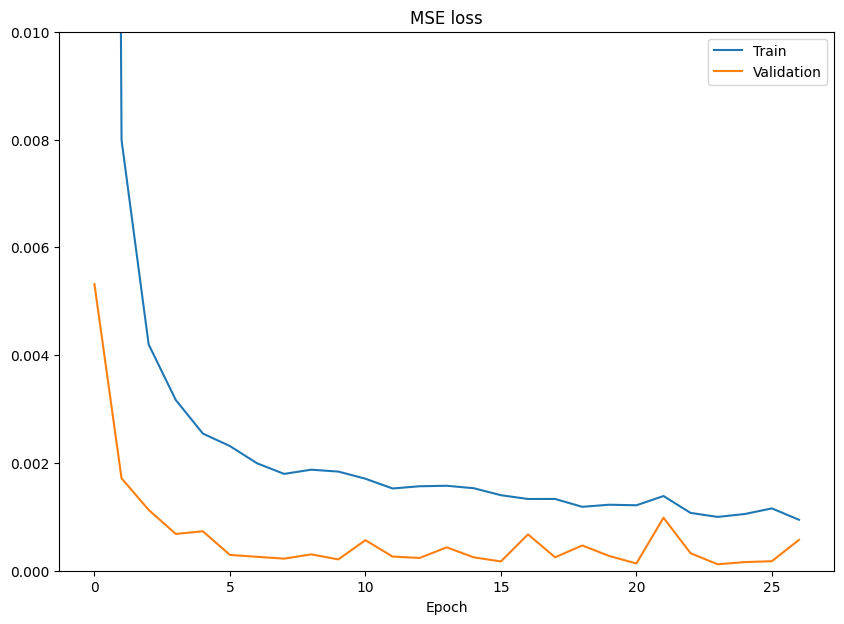

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.01)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [ ]:
np.min(val_losses)

0.00012025046686176211

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path




for root, dirs, files in os.walk('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/bcs/'):
  print(files)

dir_path = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/new_for_train'
os.makedirs(dir_path, exist_ok=True)

def boundary_func(y, params):
  u0 = params[0]
  c1 = params[1]
  c2 = params[2]
  k1 = params[3]
  k2 = params[4]
  H = 6
  u = u = (u0 / 2) * ((1 + c1 * (k1 *y)) + (1 + c2 * (k2 * y)))*y
  return u
big_data_list = list()

for file_csv in files:
  way_to_csv = os.path.join(root, file_csv)
  data = pd.read_csv(way_to_csv, header=None)

  x_lin = np.linspace(-3,3,100)
  u = boundary_func(x_lin, [data[0][0],data[0][2],data[0][3],data[0][4],data[0][5]])

  big_data_list.append(u)
  df = pd.DataFrame.from_dict(u)
  df.to_csv(os.path.join(dir_path, file_csv))
  #plt.plot(x_lin, u)

big_data = np.vstack(big_data_list)
del big_data_list
df_big_data_speed = pd.DataFrame.from_dict(big_data)
df_big_data_speed.to_csv('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/res.csv', header=None)

big_data = torch.FloatTensor(big_data).reshape(3000, 1, -1)
encoder = Autoencoder()
output = encoder(big_data)

x_train, x_val = train_test_split(big_data, test_size=0.75, shuffle=False)

['000636.csv', '002672.csv', '000389.csv', '000821.csv', '002517.csv', '000536.csv', '002317.csv', '000923.csv', '001974.csv', '000513.csv', '000800.csv', '001932.csv', '000425.csv', '002167.csv', '002172.csv', '002856.csv', '001359.csv', '001447.csv', '000993.csv', '001621.csv', '000576.csv', '001004.csv', '001970.csv', '001797.csv', '000953.csv', '000472.csv', '001672.csv', '000584.csv', '000606.csv', '001172.csv', '002999.csv', '001746.csv', '001192.csv', '001501.csv', '000369.csv', '001994.csv', '002581.csv', '000507.csv', '001584.csv', '000887.csv', '000908.csv', '001078.csv', '002037.csv', '000910.csv', '002805.csv', '002362.csv', '000871.csv', '000092.csv', '001328.csv', '002956.csv', '000984.csv', '002074.csv', '001143.csv', '001536.csv', '001458.csv', '002878.csv', '000186.csv', '000843.csv', '000700.csv', '001318.csv', '001539.csv', '000157.csv', '002419.csv', '001905.csv', '002967.csv', '000327.csv', '001831.csv', '002322.csv', '001801.csv', '000128.csv', '002555.csv', '0001

In [ ]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=10, shuffle = True)
val_loader = torch.utils.data.DataLoader(x_val, batch_size=10, shuffle = False)

# print(len(train_loader))
n_epochs = 15
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        # print(X_batch)
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


<ipython-input-55-cd0144473536>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/15 [00:00<?, ?it/s]

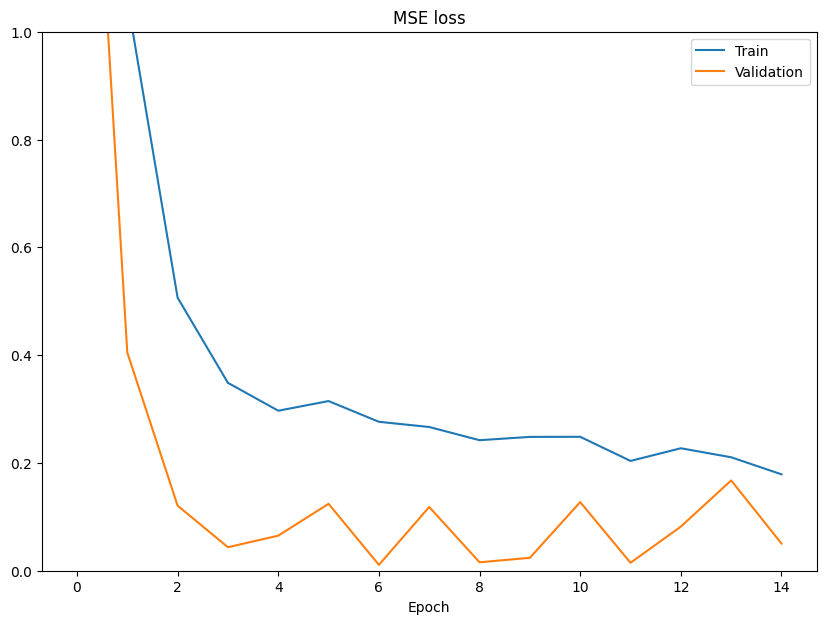

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [ ]:
np.min(val_losses)

0.010896570645272732

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path




for root, dirs, files in os.walk('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/bcs/'):
  print(files)

dir_path = 'datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/new_for_train'
os.makedirs(dir_path, exist_ok=True)

def boundary_func(y, params):
  u0 = params[0]
  c1 = params[1]
  c2 = params[2]
  k1 = params[3]
  k2 = params[4]
  H = 6
  u = (np.cos(u0) / 2) * ((1 + np.sin(c1) * (np.sin(k1) *np.cos(y))) + (1 + np.cos(c2) * (np.cos(k2) * y)))*np.sin(y)
  return u
big_data_list = list()

for file_csv in files:
  way_to_csv = os.path.join(root, file_csv)
  data = pd.read_csv(way_to_csv, header=None)

  x_lin = np.linspace(-3,3,100)
  u = boundary_func(x_lin, [data[0][0],data[0][2],data[0][3],data[0][4],data[0][5]])

  big_data_list.append(u)
  df = pd.DataFrame.from_dict(u)
  df.to_csv(os.path.join(dir_path, file_csv))
  #plt.plot(x_lin, u)

big_data = np.vstack(big_data_list)
del big_data_list
df_big_data_speed = pd.DataFrame.from_dict(big_data)
df_big_data_speed.to_csv('datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/res.csv', header=None)

big_data = torch.FloatTensor(big_data).reshape(3000, 1, -1)
encoder = Autoencoder()
output = encoder(big_data)

x_train, x_val = train_test_split(big_data, test_size=0.75, shuffle=False)

['000636.csv', '002672.csv', '000389.csv', '000821.csv', '002517.csv', '000536.csv', '002317.csv', '000923.csv', '001974.csv', '000513.csv', '000800.csv', '001932.csv', '000425.csv', '002167.csv', '002172.csv', '002856.csv', '001359.csv', '001447.csv', '000993.csv', '001621.csv', '000576.csv', '001004.csv', '001970.csv', '001797.csv', '000953.csv', '000472.csv', '001672.csv', '000584.csv', '000606.csv', '001172.csv', '002999.csv', '001746.csv', '001192.csv', '001501.csv', '000369.csv', '001994.csv', '002581.csv', '000507.csv', '001584.csv', '000887.csv', '000908.csv', '001078.csv', '002037.csv', '000910.csv', '002805.csv', '002362.csv', '000871.csv', '000092.csv', '001328.csv', '002956.csv', '000984.csv', '002074.csv', '001143.csv', '001536.csv', '001458.csv', '002878.csv', '000186.csv', '000843.csv', '000700.csv', '001318.csv', '001539.csv', '000157.csv', '002419.csv', '001905.csv', '002967.csv', '000327.csv', '001831.csv', '002322.csv', '001801.csv', '000128.csv', '002555.csv', '0001

In [ ]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=10, shuffle = True)
val_loader = torch.utils.data.DataLoader(x_val, batch_size=10, shuffle = False)

# print(len(train_loader))
n_epochs = 10
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        # print(X_batch)
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


<ipython-input-83-6f47e9aceac5>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/10 [00:00<?, ?it/s]

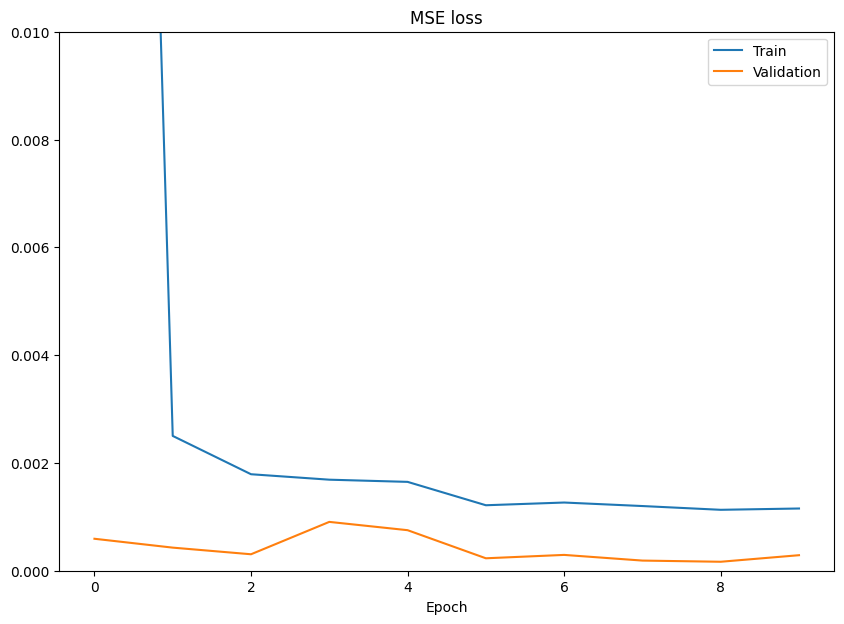

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.01)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [ ]:
np.min(val_losses)

0.0001663548332807194

In [ ]:
os.listdir('/content/GNN_bmm23/datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/bcs')

['002548.csv',
 '002965.csv',
 '002812.csv',
 '002419.csv',
 '001404.csv',
 '002386.csv',
 '001661.csv',
 '002537.csv',
 '002406.csv',
 '002476.csv',
 '002746.csv',
 '002388.csv',
 '002171.csv',
 '002807.csv',
 '002277.csv',
 '002099.csv',
 '002262.csv',
 '001343.csv',
 '001919.csv',
 '000770.csv',
 '002882.csv',
 '002694.csv',
 '002283.csv',
 '000096.csv',
 '000592.csv',
 '000074.csv',
 '002023.csv',
 '002438.csv',
 '001767.csv',
 '000923.csv',
 '001008.csv',
 '001042.csv',
 '001583.csv',
 '001637.csv',
 '001230.csv',
 '000256.csv',
 '001287.csv',
 '000242.csv',
 '002972.csv',
 '001204.csv',
 '001722.csv',
 '002743.csv',
 '000979.csv',
 '001425.csv',
 '001391.csv',
 '000140.csv',
 '001944.csv',
 '001258.csv',
 '000011.csv',
 '000151.csv',
 '000071.csv',
 '001019.csv',
 '002275.csv',
 '002074.csv',
 '000208.csv',
 '002434.csv',
 '001328.csv',
 '002231.csv',
 '002603.csv',
 '001397.csv',
 '001501.csv',
 '002735.csv',
 '001481.csv',
 '002742.csv',
 '002092.csv',
 '002435.csv',
 '001170.c

In [ ]:
os.listdir('/content/GNN_bmm23/datasets/dataset_rndshapSM_rndbc_fixobj_0.65_0.07/train/sv')

['002548.csv',
 '002965.csv',
 '002812.csv',
 '002419.csv',
 '001404.csv',
 '002386.csv',
 '001661.csv',
 '002537.csv',
 '002406.csv',
 '002476.csv',
 '002746.csv',
 '002388.csv',
 '002171.csv',
 '002807.csv',
 '002277.csv',
 '002099.csv',
 '002262.csv',
 '001343.csv',
 '001919.csv',
 '000770.csv',
 '002882.csv',
 '002694.csv',
 '002283.csv',
 '000096.csv',
 '000592.csv',
 '000074.csv',
 '002023.csv',
 '002438.csv',
 '001767.csv',
 '000923.csv',
 '001008.csv',
 '001042.csv',
 '001583.csv',
 '001637.csv',
 '001230.csv',
 '000256.csv',
 '001287.csv',
 '000242.csv',
 '002972.csv',
 '001204.csv',
 '001722.csv',
 '002743.csv',
 '000979.csv',
 '001425.csv',
 '001391.csv',
 '000140.csv',
 '001944.csv',
 '001258.csv',
 '000011.csv',
 '000151.csv',
 '000071.csv',
 '001019.csv',
 '002275.csv',
 '002074.csv',
 '000208.csv',
 '002434.csv',
 '001328.csv',
 '002231.csv',
 '002603.csv',
 '001397.csv',
 '001501.csv',
 '002735.csv',
 '001481.csv',
 '002742.csv',
 '002092.csv',
 '002435.csv',
 '001170.c